# GD_01

## 1. RESNET

### 1.1 Module

In [ ]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 5.0 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model

import urllib3
urllib3.disable_warnings()

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1.2 Function

#### 1.2.1 normalize_and_resize_img

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

#### 1.2.2 augment

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

#### 1.2.3 apply_normalize_on_dataset

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=64, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 1.3 Data

#### 1.3.1 Data load

In [ ]:
# tfds.disable_progress_bar() # 이 주석을 풀면 데이터셋 다운로드 과정의 프로그레스바가 나타나지 않는다.
(ds_train, ds_test), ds_info = tfds.load(
                                         'stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True,
                                         as_supervised=True,
                                        )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete6WP1U8/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete6WP1U8/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
num_classes = ds_info.features["label"].num_classes

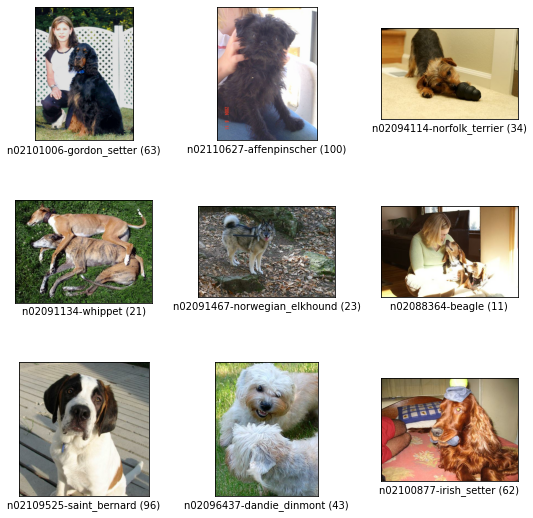

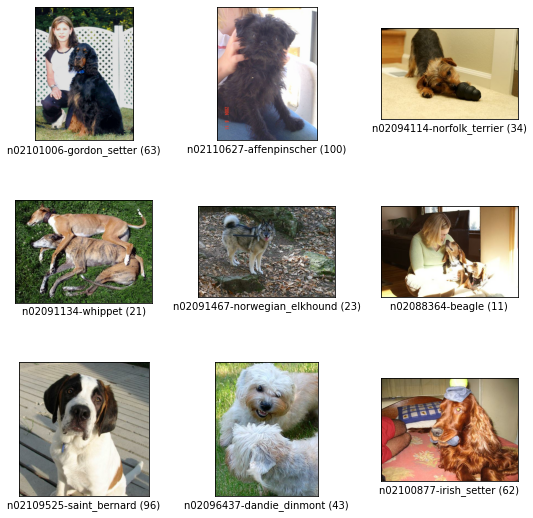

In [ ]:
tfds.show_examples(ds_train, ds_info)

#### 1.3.2 Dataset

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### 1.4 Model

#### 1.4.1 no_aug_resnet50

In [ ]:
no_aug_resnet50_0 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


#### 1.4.2 aug_resnet50

In [ ]:
aug_resnet50_0 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 1.5 Train

#### 1.5.1 No_Aug

In [ ]:
EPOCH = 20

no_aug_resnet50_0.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug_0 = no_aug_resnet50_0.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
187/187 [==============================] - 96s 371ms/step - loss: 3.2273 - accuracy: 0.3115 - val_loss: 5.2527 - val_accuracy: 0.0180
Epoch 2/20
187/187 [==============================] - 68s 364ms/step - loss: 1.2205 - accuracy: 0.7157 - val_loss: 5.0542 - val_accuracy: 0.0159
Epoch 3/20
187/187 [==============================] - 76s 408ms/step - loss: 0.7128 - accuracy: 0.8403 - val_loss: 4.9171 - val_accuracy: 0.0259
Epoch 4/20
187/187 [==============================] - 68s 365ms/step - loss: 0.3967 - accuracy: 0.9266 - val_loss: 3.1954 - val_accuracy: 0.2439
Epoch 5/20
187/187 [==============================] - 68s 363ms/step - loss: 0.2408 - accuracy: 0.9670 - val_loss: 1.5770 - val_accuracy: 0.5628
Epoch 6/20
187/187 [==============================] - 68s 365ms/step - loss: 0.1483 - accuracy: 0.9858 - val_loss: 1.0390 - val_accuracy: 0.6968
Epoch 7/20
187/187 [==============================] - 68s 365ms/step - loss: 0.1017 - accuracy: 0.9942 - val_loss: 0.9761 - val_ac

#### 1.5.2 Aug

In [ ]:
aug_resnet50_0.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_0 = aug_resnet50_0.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
187/187 [==============================] - 82s 368ms/step - loss: 3.3155 - accuracy: 0.2888 - val_loss: 5.1972 - val_accuracy: 0.0115
Epoch 2/20
187/187 [==============================] - 68s 365ms/step - loss: 1.4000 - accuracy: 0.6580 - val_loss: 5.1450 - val_accuracy: 0.0097
Epoch 3/20
187/187 [==============================] - 68s 366ms/step - loss: 0.8806 - accuracy: 0.7761 - val_loss: 4.8706 - val_accuracy: 0.0300
Epoch 4/20
187/187 [==============================] - 68s 365ms/step - loss: 0.6246 - accuracy: 0.8455 - val_loss: 2.7687 - val_accuracy: 0.3094
Epoch 5/20
187/187 [==============================] - 68s 364ms/step - loss: 0.4471 - accuracy: 0.8968 - val_loss: 1.3369 - val_accuracy: 0.6119
Epoch 6/20
187/187 [==============================] - 68s 365ms/step - loss: 0.3349 - accuracy: 0.9320 - val_loss: 1.0094 - val_accuracy: 0.6996
Epoch 7/20
187/187 [==============================] - 68s 366ms/step - loss: 0.2463 - accuracy: 0.9559 - val_loss: 0.9526 - val_ac

#### 1.5.1 Compare

##### 1) Validation Accuracy

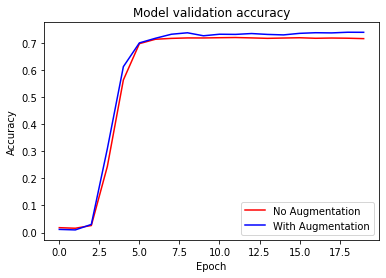

In [ ]:
plt.plot(history_resnet50_no_aug_0.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_0.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='lower right')
plt.show()

##### 2) Validation Accuracy_xlim(0.65~0.76)

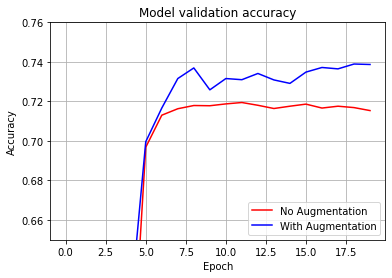

In [ ]:
plt.plot(history_resnet50_no_aug_0.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_0.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='lower right')
plt.grid(True)
plt.ylim(0.65, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## 2. Augmentation

### 2.1 CutMix Augmentation

- No_Augment 데이터셋에서 이미지를 골라 섞어줍니다.

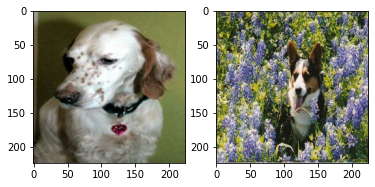

In [ ]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

- image_a를 기준으로 랜덤하게 x, y 값을 뽑아 박스를 만듭니다.

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast(tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width  = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x - width //  2)
    y_min = tf.math.maximum(0, y - height // 2)
    x_max = tf.math.minimum(image_size_x, x + width // 2)
    y_max = tf.math.minimum(image_size_y, y + width // 2)
    
    return x_min, y_min, x_max, y_max

- a, b 이미지에서 x_min, y_min, x_max, y_max 값을 찍습니다.

In [ ]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
print(x_min, y_min, x_max, y_max)

tf.Tensor(17, shape=(), dtype=int32) tf.Tensor(61, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(215, shape=(), dtype=int32)


- a, b 이미지를 불러와 concat합니다.

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min : y_max, 0 : x_min, :]
    middle_center = image_b[y_min : y_max, x_min : x_max, :]
    middle_right = image_a[y_min : y_max, x_max : image_size_x, :]
    middle = tf.concat([middle_left,middle_center,middle_right], axis = 1)
    top = image_a[0 : y_min, :, :]
    bottom = image_a[y_max : image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis = 0)
    
    return mixed_img

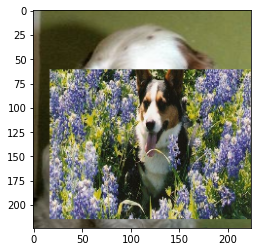

In [ ]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())

- 두 이미지의 label이 다르므로 label도 섞어줘야 합니다.

In [ ]:
# mix two labels
def mix_2_label(label_a, label_b, x_min, y_min, x_max, y_max, num_classes = 120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

In [ ]:
mixed_label = mix_2_label(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.36467636, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

- 위에서 수행한 mix_2_images와 mix_2_label을 활용하여 cutmix 함수를 만듭니다.

In [ ]:
def cutmix(image, label, prob = 1.0, batch_size = 32, img_size = 224, num_classes = 120):
    mixed_imgs   = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        
        mixed_imgs.append(mix_2_images(image_a,  image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_label(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 2.2 MixUp Augmentation

In [ ]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([],0,1)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    
    return mixed_image, mixed_label

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.62991846 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

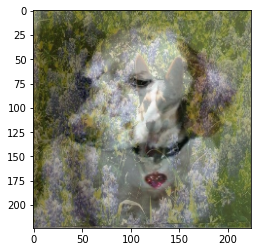

In [ ]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

- 마찬가지로 mixup_2_images를 활용해 배치 단위로 섞어줄 mixup 함수를 만듭니다.

In [ ]:
def mixup(image, label, prob = 1.0, batch_size = 32, img_size = 224, num_classes = 120):
    mixed_imgs   = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 2.3 Dataset

In [ ]:
def onehot(image, label, prob = 1.0, batch_size = 32, img_size = 224, num_classes = 120):
    imgs   = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    
    return onehot_imgs, labels

In [ ]:
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 32, with_aug = False, with_cutmix = False, with_mixup = False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls = 2)
    
    if not is_test and with_aug:     # basic augmentation
        ds = ds.map(augment_2)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:  # cutmix
        ds = ds.map(cutmix, num_parallel_calls = 2)
        
    elif not is_test and with_mixup: # mixup
        ds = ds.map(mixup, num_parallel_calls = 2)
        
    else:
        ds = ds.map(onehot, num_parallel_calls = 2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split = ["train", "test"],
    as_supervised = True,
    shuffle_files = True,
    with_info = True
)

In [ ]:
ds_train_aug_one = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix = True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup  = True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

### 2.4 Model

#### 2.4.1 CutMix

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#### 2.4.2 MixUp

In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 2.5 Train

#### 2.5.1 CutMix

In [ ]:
EPOCH = 20

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
375/375 [==============================] - 165s 379ms/step - loss: 4.0774 - accuracy: 0.1645 - val_loss: 5.1265 - val_accuracy: 0.0097
Epoch 2/20
375/375 [==============================] - 158s 422ms/step - loss: 3.0792 - accuracy: 0.3998 - val_loss: 2.8933 - val_accuracy: 0.2809
Epoch 3/20
375/375 [==============================] - 158s 422ms/step - loss: 2.7733 - accuracy: 0.4947 - val_loss: 1.2688 - val_accuracy: 0.6635
Epoch 4/20
375/375 [==============================] - 158s 422ms/step - loss: 2.5271 - accuracy: 0.5648 - val_loss: 1.2496 - val_accuracy: 0.6687
Epoch 5/20
375/375 [==============================] - 158s 423ms/step - loss: 2.4117 - accuracy: 0.6049 - val_loss: 1.1212 - val_accuracy: 0.7011
Epoch 6/20
375/375 [==============================] - 159s 423ms/step - loss: 2.3033 - accuracy: 0.6413 - val_loss: 1.1160 - val_accuracy: 0.7092
Epoch 7/20
375/375 [==============================] - 158s 423ms/step - loss: 2.2115 - accuracy: 0.6663 - val_loss: 1.0869 -

#### 2.5.2 MixUp

In [ ]:
EPOCH = 20

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
375/375 [==============================] - 168s 424ms/step - loss: 3.8709 - accuracy: 0.2231 - val_loss: 5.3364 - val_accuracy: 0.0103
Epoch 2/20
375/375 [==============================] - 158s 421ms/step - loss: 2.9288 - accuracy: 0.4683 - val_loss: 3.2447 - val_accuracy: 0.2352
Epoch 3/20
375/375 [==============================] - 171s 456ms/step - loss: 2.6317 - accuracy: 0.5669 - val_loss: 1.6586 - val_accuracy: 0.5497
Epoch 4/20
375/375 [==============================] - 172s 458ms/step - loss: 2.4680 - accuracy: 0.6302 - val_loss: 1.2209 - val_accuracy: 0.6614
Epoch 5/20
375/375 [==============================] - 172s 458ms/step - loss: 2.3411 - accuracy: 0.6835 - val_loss: 1.1537 - val_accuracy: 0.6887
Epoch 6/20
375/375 [==============================] - 159s 423ms/step - loss: 2.2374 - accuracy: 0.7255 - val_loss: 1.1126 - val_accuracy: 0.7011
Epoch 7/20
375/375 [==============================] - 159s 423ms/step - loss: 2.1744 - accuracy: 0.7481 - val_loss: 1.1259 -

#### 3.1.3 Compare

##### 1) Validation Accuracy

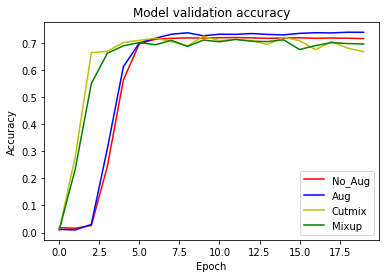

In [ ]:
plt.plot(history_resnet50_no_aug_0.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_0.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No_Aug', 'Aug', 'Cutmix', 'Mixup'], loc='lower right')
plt.show()

##### 2) Validation Accuracy_xlim(0.6~0.76)

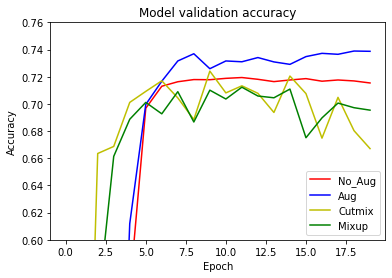

In [ ]:
plt.plot(history_resnet50_no_aug_0.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_0.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.6, 0.76)
plt.legend(['No_Aug', 'Aug', 'Cutmix', 'Mixup'], loc='lower right')
plt.show()

## 3. Re_Start

### 3.1 Add_Augmentation

- 기존 기본 Augmentation은 랜덤하게 flip, brightness만 적용했는데,  
이번에는 pad를 20씩 부여하고 (224,224)크기로 random crop, filp, brightness를 적용합니다.

#### 3.1.1 Function

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset_2(ds, is_test=False, batch_size=64, with_aug_2=False, with_aug_3=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug_2:
        ds = ds.map(
            augment_2,       # augment_2 함수 적용
            num_parallel_calls=2
        )
    if not is_test and with_aug_3:
        ds = ds.map(
            augment_3,       # augment_3 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
def augment_2(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 224 + 10, 224 + 10)
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3) # Random brightness
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
def augment_3(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 224 + 10, 224 + 10)
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 5, 10)
    image = tf.image.random_brightness(image, max_delta=0.3) # Random brightness
    image = tf.clip_by_value(image, 0, 1)
    return image, label

#### 4.1.2 Dataset

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
                                         'stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True,
                                         as_supervised=True
                                        )

In [ ]:
num_classes = ds_info.features['label'].num_classes
print(num_classes)

120


In [ ]:
ds_train_no_aug = apply_normalize_on_dataset_2(ds_train, with_aug=False)
ds_train_tf_aug_2 = apply_normalize_on_dataset_2(ds_train, with_aug_2=True)
ds_train_tf_aug_3 = apply_normalize_on_dataset_2(ds_train, with_aug_3=True)
ds_test = apply_normalize_on_dataset_2(ds_test, is_test=True)

### 3.2 Model

#### 3.2.1 No_Aug

In [ ]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#### 3.2.2 Aug_2(simple)

In [ ]:
aug_resnet50_1 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#### 3.2.3 Aug_3(complex)

In [ ]:
aug_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#### 3.2.4 Cutmix(epoch 200)

In [ ]:
cutmix_resnet50_1 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#### 3.2.5 CutMix & MixUp

In [ ]:
cutmix_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#### 3.2.6 CutMix & Aug

In [ ]:
cutmix_resnet50_3 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#### 3.2.7 MixUp & Aug

In [ ]:
cutmix_resnet50_4 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#### 3.2.8 CutMix & MixUp & Aug

In [ ]:
cutmix_resnet50_5 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#### 3.2.9 Cutmix(Adam Optimizer)

In [ ]:
cutmix_resnet50_6 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 3.3 Train

#### 3.3.1 No_Aug(Default)

In [ ]:
EPOCH = 50

no_aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # no_aug 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
187/187 [==============================] - 90s 374ms/step - loss: 3.1938 - accuracy: 0.3268 - val_loss: 5.6879 - val_accuracy: 0.0175
Epoch 2/50
187/187 [==============================] - 69s 369ms/step - loss: 1.2539 - accuracy: 0.7049 - val_loss: 5.2736 - val_accuracy: 0.0139
Epoch 3/50
187/187 [==============================] - 69s 369ms/step - loss: 0.6997 - accuracy: 0.8381 - val_loss: 5.0391 - val_accuracy: 0.0147
Epoch 4/50
187/187 [==============================] - 69s 369ms/step - loss: 0.4096 - accuracy: 0.9236 - val_loss: 3.3506 - val_accuracy: 0.2192
Epoch 5/50
187/187 [==============================] - 69s 371ms/step - loss: 0.2460 - accuracy: 0.9653 - val_loss: 1.6872 - val_accuracy: 0.5399
Epoch 6/50
187/187 [==============================] - 69s 370ms/step - loss: 0.1469 - accuracy: 0.9868 - val_loss: 1.0457 - val_accuracy: 0.6997
Epoch 7/50
187/187 [==============================] - 69s 370ms/step - loss: 0.1117 - accuracy: 0.9924 - val_loss: 0.9965 - val_ac

#### 3.3.2 Aug_2(simple)

In [ ]:
EPOCH = 50

aug_resnet50_1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50_1 = aug_resnet50_1.fit(
    ds_train_tf_aug_2, # aug_2 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
187/187 [==============================] - 176s 832ms/step - loss: 3.4044 - accuracy: 0.2582 - val_loss: 5.1435 - val_accuracy: 0.0125
Epoch 2/50
187/187 [==============================] - 154s 825ms/step - loss: 1.5192 - accuracy: 0.6106 - val_loss: 5.0204 - val_accuracy: 0.0136
Epoch 3/50
187/187 [==============================] - 154s 824ms/step - loss: 1.0441 - accuracy: 0.7213 - val_loss: 4.7353 - val_accuracy: 0.0311
Epoch 4/50
187/187 [==============================] - 154s 823ms/step - loss: 0.7874 - accuracy: 0.7881 - val_loss: 2.5654 - val_accuracy: 0.3547
Epoch 5/50
187/187 [==============================] - 155s 829ms/step - loss: 0.6307 - accuracy: 0.8320 - val_loss: 1.4724 - val_accuracy: 0.5802
Epoch 6/50
187/187 [==============================] - 155s 827ms/step - loss: 0.4994 - accuracy: 0.8702 - val_loss: 1.0586 - val_accuracy: 0.6856
Epoch 7/50
187/187 [==============================] - 167s 894ms/step - loss: 0.4308 - accuracy: 0.8913 - val_loss: 0.9278 -

#### 3.3.3 Aug_3(complex)

In [ ]:
EPOCH = 50

aug_resnet50_2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_aug_resnet50_2 = aug_resnet50_2.fit(
    ds_train_tf_aug_3, # aug_3 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/64),
    validation_steps=int(ds_info.splits['test'].num_examples/64),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
187/187 [==============================] - 180s 768ms/step - loss: 4.2938 - accuracy: 0.0903 - val_loss: 5.7341 - val_accuracy: 0.0070
Epoch 2/50
187/187 [==============================] - 141s 754ms/step - loss: 2.6679 - accuracy: 0.3470 - val_loss: 5.1262 - val_accuracy: 0.0069
Epoch 3/50
187/187 [==============================] - 142s 758ms/step - loss: 1.9689 - accuracy: 0.4794 - val_loss: 4.4391 - val_accuracy: 0.0647
Epoch 4/50
187/187 [==============================] - 141s 756ms/step - loss: 1.6146 - accuracy: 0.5624 - val_loss: 2.5093 - val_accuracy: 0.3420
Epoch 5/50
187/187 [==============================] - 157s 842ms/step - loss: 1.3673 - accuracy: 0.6222 - val_loss: 1.8670 - val_accuracy: 0.4837
Epoch 6/50
187/187 [==============================] - 142s 761ms/step - loss: 1.1801 - accuracy: 0.6730 - val_loss: 1.7028 - val_accuracy: 0.5118
Epoch 7/50
187/187 [==============================] - 141s 753ms/step - loss: 1.0344 - accuracy: 0.7161 - val_loss: 1.6756 -

#### 3.3.4 CutMix(epoch 200)

In [ ]:
EPOCH = 200

cutmix_resnet50_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50_1 = cutmix_resnet50_1.fit(
    ds_train_cutmix, # cutmix 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/200
375/375 [==============================] - 103s 211ms/step - loss: 4.0923 - accuracy: 0.1622 - val_loss: 5.3572 - val_accuracy: 0.0079
Epoch 2/200
375/375 [==============================] - 78s 207ms/step - loss: 3.0841 - accuracy: 0.4022 - val_loss: 3.2834 - val_accuracy: 0.2208
Epoch 3/200
375/375 [==============================] - 78s 207ms/step - loss: 2.7383 - accuracy: 0.5050 - val_loss: 1.3134 - val_accuracy: 0.6395
Epoch 4/200
375/375 [==============================] - 77s 207ms/step - loss: 2.5690 - accuracy: 0.5567 - val_loss: 1.2584 - val_accuracy: 0.6569
Epoch 5/200
375/375 [==============================] - 77s 207ms/step - loss: 2.4274 - accuracy: 0.6018 - val_loss: 1.0852 - val_accuracy: 0.7025
Epoch 6/200
375/375 [==============================] - 83s 222ms/step - loss: 2.3173 - accuracy: 0.6338 - val_loss: 1.0380 - val_accuracy: 0.7222
Epoch 7/200
375/375 [==============================] - 78s 207ms/step - loss: 2.2105 - accuracy: 0.6727 - val_loss: 1.0860 

#### 3.3.5 CutMix & MixUp

In [ ]:
EPOCH = 25

cutmix_resnet50_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50_2 = cutmix_resnet50_2.fit(
    ds_train_cutmix, # cutmix 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
375/375 [==============================] - 89s 209ms/step - loss: 4.0718 - accuracy: 0.1642 - val_loss: 5.1383 - val_accuracy: 0.0145
Epoch 2/25
375/375 [==============================] - 78s 208ms/step - loss: 3.0902 - accuracy: 0.3976 - val_loss: 3.1583 - val_accuracy: 0.2463
Epoch 3/25
375/375 [==============================] - 78s 207ms/step - loss: 2.7675 - accuracy: 0.4999 - val_loss: 1.3835 - val_accuracy: 0.6205
Epoch 4/25
375/375 [==============================] - 77s 207ms/step - loss: 2.5663 - accuracy: 0.5548 - val_loss: 1.3204 - val_accuracy: 0.6564
Epoch 5/25
375/375 [==============================] - 83s 223ms/step - loss: 2.4179 - accuracy: 0.6021 - val_loss: 1.2105 - val_accuracy: 0.6853
Epoch 6/25
375/375 [==============================] - 77s 206ms/step - loss: 2.2712 - accuracy: 0.6482 - val_loss: 1.1241 - val_accuracy: 0.6985
Epoch 7/25
375/375 [==============================] - 78s 209ms/step - loss: 2.1980 - accuracy: 0.6740 - val_loss: 1.1119 - val_ac

In [ ]:
EPOCH = 25

cutmix_resnet50_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50_2 = cutmix_resnet50_2.fit(
    ds_train_mixup, # mixup 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
375/375 [==============================] - 94s 226ms/step - loss: 1.9373 - accuracy: 0.8193 - val_loss: 1.5040 - val_accuracy: 0.6638
Epoch 2/25
375/375 [==============================] - 79s 211ms/step - loss: 1.8979 - accuracy: 0.8284 - val_loss: 1.3912 - val_accuracy: 0.6838
Epoch 3/25
375/375 [==============================] - 79s 210ms/step - loss: 1.8460 - accuracy: 0.8393 - val_loss: 1.4565 - val_accuracy: 0.6785
Epoch 4/25
375/375 [==============================] - 79s 211ms/step - loss: 1.8230 - accuracy: 0.8445 - val_loss: 1.3663 - val_accuracy: 0.6856
Epoch 5/25
375/375 [==============================] - 79s 211ms/step - loss: 1.8151 - accuracy: 0.8430 - val_loss: 1.3275 - val_accuracy: 0.7015
Epoch 6/25
375/375 [==============================] - 79s 210ms/step - loss: 1.7930 - accuracy: 0.8494 - val_loss: 1.3350 - val_accuracy: 0.7002
Epoch 7/25
375/375 [==============================] - 79s 211ms/step - loss: 1.7971 - accuracy: 0.8452 - val_loss: 1.4416 - val_ac

#### 3.3.6 CutMix & Aug(s)

In [ ]:
EPOCH = 25

cutmix_resnet50_3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50_3 = cutmix_resnet50_3.fit(
    ds_train_cutmix, # cutmix 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
375/375 [==============================] - 89s 212ms/step - loss: 4.0947 - accuracy: 0.1674 - val_loss: 5.3146 - val_accuracy: 0.0082
Epoch 2/25
375/375 [==============================] - 78s 209ms/step - loss: 3.0681 - accuracy: 0.4009 - val_loss: 3.5667 - val_accuracy: 0.1838
Epoch 3/25
375/375 [==============================] - 78s 209ms/step - loss: 2.7492 - accuracy: 0.5008 - val_loss: 1.3462 - val_accuracy: 0.6291
Epoch 4/25
375/375 [==============================] - 78s 209ms/step - loss: 2.5420 - accuracy: 0.5659 - val_loss: 1.1998 - val_accuracy: 0.6733
Epoch 5/25
375/375 [==============================] - 78s 209ms/step - loss: 2.4140 - accuracy: 0.6036 - val_loss: 1.1512 - val_accuracy: 0.6979
Epoch 6/25
375/375 [==============================] - 84s 224ms/step - loss: 2.2986 - accuracy: 0.6411 - val_loss: 1.0533 - val_accuracy: 0.7123
Epoch 7/25
375/375 [==============================] - 79s 209ms/step - loss: 2.2035 - accuracy: 0.6712 - val_loss: 1.1272 - val_ac

In [ ]:
EPOCH = 25

cutmix_resnet50_3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50_3 = cutmix_resnet50_3.fit(
    ds_train_aug_one, # aug 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
375/375 [==============================] - 89s 211ms/step - loss: 0.2517 - accuracy: 0.9388 - val_loss: 1.1758 - val_accuracy: 0.6804
Epoch 2/25
375/375 [==============================] - 78s 209ms/step - loss: 0.1781 - accuracy: 0.9567 - val_loss: 1.0767 - val_accuracy: 0.7029
Epoch 3/25
375/375 [==============================] - 78s 208ms/step - loss: 0.1267 - accuracy: 0.9720 - val_loss: 0.9810 - val_accuracy: 0.7288
Epoch 4/25
375/375 [==============================] - 78s 208ms/step - loss: 0.0943 - accuracy: 0.9801 - val_loss: 1.0569 - val_accuracy: 0.7109
Epoch 5/25
375/375 [==============================] - 78s 208ms/step - loss: 0.0779 - accuracy: 0.9852 - val_loss: 0.9249 - val_accuracy: 0.7460
Epoch 6/25
375/375 [==============================] - 78s 209ms/step - loss: 0.0631 - accuracy: 0.9880 - val_loss: 1.0116 - val_accuracy: 0.7273
Epoch 7/25
375/375 [==============================] - 78s 207ms/step - loss: 0.0505 - accuracy: 0.9923 - val_loss: 0.9510 - val_ac

#### 3.3.7 MixUp & Aug(s)

In [ ]:
EPOCH = 25

cutmix_resnet50_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50_4 = cutmix_resnet50_4.fit(
    ds_train_mixup, # mixup 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
375/375 [==============================] - 87s 209ms/step - loss: 3.8876 - accuracy: 0.2237 - val_loss: 5.3137 - val_accuracy: 0.0098
Epoch 2/25
375/375 [==============================] - 79s 212ms/step - loss: 2.9012 - accuracy: 0.4716 - val_loss: 3.4925 - val_accuracy: 0.1934
Epoch 3/25
375/375 [==============================] - 85s 226ms/step - loss: 2.6347 - accuracy: 0.5689 - val_loss: 1.5123 - val_accuracy: 0.6100
Epoch 4/25
375/375 [==============================] - 84s 225ms/step - loss: 2.4443 - accuracy: 0.6443 - val_loss: 1.2868 - val_accuracy: 0.6522
Epoch 5/25
375/375 [==============================] - 79s 210ms/step - loss: 2.3325 - accuracy: 0.6835 - val_loss: 1.1932 - val_accuracy: 0.6750
Epoch 6/25
375/375 [==============================] - 79s 211ms/step - loss: 2.2412 - accuracy: 0.7177 - val_loss: 1.1925 - val_accuracy: 0.6867
Epoch 7/25
375/375 [==============================] - 79s 210ms/step - loss: 2.1685 - accuracy: 0.7467 - val_loss: 1.1289 - val_ac

In [ ]:
EPOCH = 25

cutmix_resnet50_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50_4 = cutmix_resnet50_4.fit(
    ds_train_aug_one,    # aug 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
375/375 [==============================] - 89s 210ms/step - loss: 0.2924 - accuracy: 0.9414 - val_loss: 1.0867 - val_accuracy: 0.7028
Epoch 2/25
375/375 [==============================] - 78s 208ms/step - loss: 0.2003 - accuracy: 0.9555 - val_loss: 0.9855 - val_accuracy: 0.7278
Epoch 3/25
375/375 [==============================] - 78s 207ms/step - loss: 0.1262 - accuracy: 0.9753 - val_loss: 0.9428 - val_accuracy: 0.7364
Epoch 4/25
375/375 [==============================] - 79s 209ms/step - loss: 0.0925 - accuracy: 0.9824 - val_loss: 0.9657 - val_accuracy: 0.7317
Epoch 5/25
375/375 [==============================] - 79s 211ms/step - loss: 0.0817 - accuracy: 0.9861 - val_loss: 1.0572 - val_accuracy: 0.7150
Epoch 6/25
375/375 [==============================] - 84s 223ms/step - loss: 0.0659 - accuracy: 0.9900 - val_loss: 1.0138 - val_accuracy: 0.7264
Epoch 7/25
375/375 [==============================] - 78s 208ms/step - loss: 0.0580 - accuracy: 0.9915 - val_loss: 0.9498 - val_ac

#### 3.3.8 CutMix & MixUp & Aug(s)

In [ ]:
EPOCH = 25

cutmix_resnet50_5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50_5 = cutmix_resnet50_5.fit(
    ds_train_cutmix, # cutmix 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
375/375 [==============================] - 89s 209ms/step - loss: 4.0718 - accuracy: 0.1642 - val_loss: 5.1383 - val_accuracy: 0.0145
Epoch 2/25
375/375 [==============================] - 78s 208ms/step - loss: 3.0902 - accuracy: 0.3976 - val_loss: 3.1583 - val_accuracy: 0.2463
Epoch 3/25
375/375 [==============================] - 78s 207ms/step - loss: 2.7675 - accuracy: 0.4999 - val_loss: 1.3835 - val_accuracy: 0.6205
Epoch 4/25
375/375 [==============================] - 77s 207ms/step - loss: 2.5663 - accuracy: 0.5548 - val_loss: 1.3204 - val_accuracy: 0.6564
Epoch 5/25
375/375 [==============================] - 83s 223ms/step - loss: 2.4179 - accuracy: 0.6021 - val_loss: 1.2105 - val_accuracy: 0.6853
Epoch 6/25
375/375 [==============================] - 77s 206ms/step - loss: 2.2712 - accuracy: 0.6482 - val_loss: 1.1241 - val_accuracy: 0.6985
Epoch 7/25
375/375 [==============================] - 78s 209ms/step - loss: 2.1980 - accuracy: 0.6740 - val_loss: 1.1119 - val_ac

In [ ]:
EPOCH = 25

cutmix_resnet50_5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50_5 = cutmix_resnet50_5.fit(
    ds_train_mixup, # mixup 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
375/375 [==============================] - 94s 226ms/step - loss: 1.9373 - accuracy: 0.8193 - val_loss: 1.5040 - val_accuracy: 0.6638
Epoch 2/25
375/375 [==============================] - 79s 211ms/step - loss: 1.8979 - accuracy: 0.8284 - val_loss: 1.3912 - val_accuracy: 0.6838
Epoch 3/25
375/375 [==============================] - 79s 210ms/step - loss: 1.8460 - accuracy: 0.8393 - val_loss: 1.4565 - val_accuracy: 0.6785
Epoch 4/25
375/375 [==============================] - 79s 211ms/step - loss: 1.8230 - accuracy: 0.8445 - val_loss: 1.3663 - val_accuracy: 0.6856
Epoch 5/25
375/375 [==============================] - 79s 211ms/step - loss: 1.8151 - accuracy: 0.8430 - val_loss: 1.3275 - val_accuracy: 0.7015
Epoch 6/25
375/375 [==============================] - 79s 210ms/step - loss: 1.7930 - accuracy: 0.8494 - val_loss: 1.3350 - val_accuracy: 0.7002
Epoch 7/25
375/375 [==============================] - 79s 211ms/step - loss: 1.7971 - accuracy: 0.8452 - val_loss: 1.4416 - val_ac

In [ ]:
EPOCH = 25

cutmix_resnet50_5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cutmix_resnet50_5 = cutmix_resnet50_5.fit(
    ds_train_aug_one, # aug 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
375/375 [==============================] - 88s 209ms/step - loss: 0.2130 - accuracy: 0.9541 - val_loss: 0.9752 - val_accuracy: 0.7310
Epoch 2/25
375/375 [==============================] - 78s 208ms/step - loss: 0.1241 - accuracy: 0.9726 - val_loss: 1.0333 - val_accuracy: 0.7169
Epoch 3/25
375/375 [==============================] - 78s 208ms/step - loss: 0.0923 - accuracy: 0.9812 - val_loss: 0.9806 - val_accuracy: 0.7302
Epoch 4/25
375/375 [==============================] - 77s 207ms/step - loss: 0.0711 - accuracy: 0.9859 - val_loss: 1.1508 - val_accuracy: 0.6974
Epoch 5/25
375/375 [==============================] - 77s 207ms/step - loss: 0.0528 - accuracy: 0.9905 - val_loss: 0.9297 - val_accuracy: 0.7452
Epoch 6/25
375/375 [==============================] - 77s 206ms/step - loss: 0.0485 - accuracy: 0.9920 - val_loss: 0.9311 - val_accuracy: 0.7460
Epoch 7/25
375/375 [==============================] - 77s 206ms/step - loss: 0.0370 - accuracy: 0.9935 - val_loss: 0.9556 - val_ac

#### 3.3.9 CutMix(Adam Optimizer)

In [ ]:
EPOCH = 50

cutmix_resnet50_6.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    metrics=['accuracy'],
)

history_cutmix_resnet50_6 = cutmix_resnet50_6.fit(
    ds_train_cutmix, # cutmix 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
375/375 [==============================] - 96s 218ms/step - loss: 4.8210 - accuracy: 0.0117 - val_loss: 4.7867 - val_accuracy: 0.0058
Epoch 2/50
375/375 [==============================] - 81s 215ms/step - loss: 4.7098 - accuracy: 0.0162 - val_loss: 4.9825 - val_accuracy: 0.0061
Epoch 3/50
375/375 [==============================] - 80s 214ms/step - loss: 4.6190 - accuracy: 0.0233 - val_loss: 4.4482 - val_accuracy: 0.0325
Epoch 4/50
375/375 [==============================] - 81s 216ms/step - loss: 4.5048 - accuracy: 0.0402 - val_loss: 5.5530 - val_accuracy: 0.0294
Epoch 5/50
375/375 [==============================] - 81s 217ms/step - loss: 4.3703 - accuracy: 0.0576 - val_loss: 4.7332 - val_accuracy: 0.0625
Epoch 6/50
375/375 [==============================] - 81s 216ms/step - loss: 4.2284 - accuracy: 0.0828 - val_loss: 4.6735 - val_accuracy: 0.0604
Epoch 7/50
375/375 [==============================] - 81s 216ms/step - loss: 4.1063 - accuracy: 0.1025 - val_loss: 3.8031 - val_ac

#### 3.3.6 Compare

##### 1) Default, Aug, CutMix

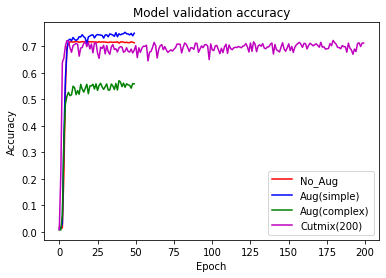

In [ ]:
plt.plot(history_no_aug_resnet50, 'r')
plt.plot(history_aug_resnet50_1, 'b')
plt.plot(history_aug_resnet50_2, 'g')
plt.plot(history_cutmix_resnet50_1, 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No_Aug', 'Aug(simple)', 'Aug(complex)', 'Cutmix(200)'], loc='lower right')
plt.show()

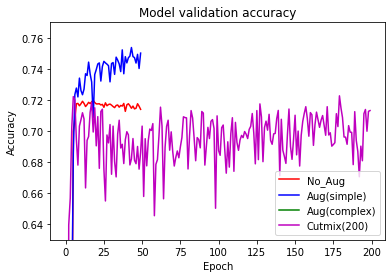

In [ ]:
plt.plot(history_no_aug_resnet50, 'r')
plt.plot(history_aug_resnet50_1, 'b')
plt.plot(history_aug_resnet50_2, 'g')
plt.plot(history_cutmix_resnet50_1, 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.63, 0.77)
plt.legend(['No_Aug', 'Aug(simple)', 'Aug(complex)', 'Cutmix(200)'], loc='lower right')
plt.show()

##### 2) Default, Aug, Mixed

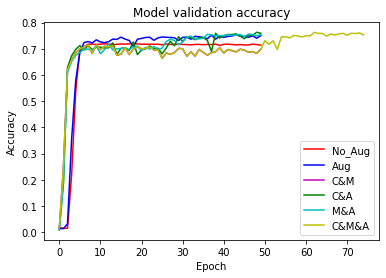

In [ ]:
plt.plot(history_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50_1.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50_2.history['val_accuracy'], 'm')
plt.plot(history_cutmix_resnet50_3.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50_4.history['val_accuracy'], 'c')
plt.plot(history_cutmix_resnet50_5.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No_Aug', 'Aug(s)', 'C&M', 'C&A', 'M&A', 'C&M&A'], loc='lower right')
plt.show()

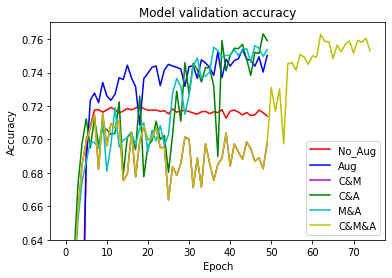

In [ ]:
plt.plot(history_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50_1.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50_2.history['val_accuracy'], 'm')
plt.plot(history_cutmix_resnet50_3.history['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50_4.history['val_accuracy'], 'c')
plt.plot(history_cutmix_resnet50_5.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.64, 0.77)
plt.legend(['No_Aug', 'Aug(s)', 'C&M', 'C&A', 'M&A', 'C&M&A'], loc='lower right')
plt.show()

## 4. Conclusion

### 4.1 Best

- 일반 default값과 비교해보면, CutMix & Augmentation을 훈련한 모델이 가장 좋은 성능을 보여줍니다.  
epoch의 마지막단에 가서는 5% 수준의 성능 향상까지 끌어왔습니다.

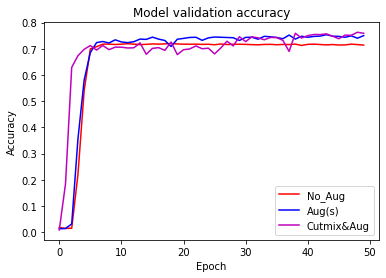

In [ ]:
plt.plot(history_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50_1.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50_2.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No_Aug', 'Aug(s)', 'Cutmix&Aug'], loc='lower right')
plt.show()

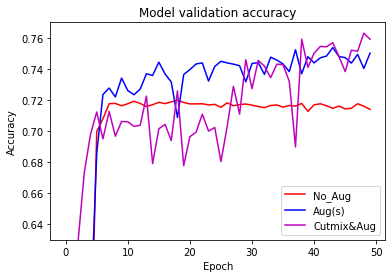

In [ ]:
plt.plot(history_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50_1.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50_2.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.63, 0.77)
plt.legend(['No_Aug', 'Aug(s)', 'Cutmix&Aug'], loc='lower right')
plt.show()

## 5. Retrospect

##### 1) Augmentation
- cut&mix, mixup을 한 경우 오히려 val_accuracy 값이 default보다 떨어집니다.  
추측해보건대 기본적으로 구도가 비슷한 사진에서(예를 들면 정면만 바라본 사진) 위 기법들이 유의미할 것 같은데 이번에는 위치, 구도도 제각각이고, 사람 같은 노이즈 있는 사진도 많다 보니 cut&mix, mixup이 오히려 정확도를 떨어트리지 않았나 생각합니다.

##### 2) Train
- 결국 어떤 모델이든 CutMix, MixUp, Augmentation을 적절히 학습시켜야 조금이라도 성능을 끌어올릴 수 있습니다.  
적당한 epoch로 train set을 바꿔가며 훈련시키는 것도 좋을 것 같습니다.  
이번 학습에서는 CutMix 나 MixUp으로 학습한 모델에 Augmentation 추가로 학습시키면 최상의 결과를 도출할 수 있습니다.  
epoch의 마지막단에 가서는 5% 수준의 성능 향상까지 끌어왔습니다.

##### 3) Keras CV
- Keras CV라는 Augmentation Pipeline이 있지만, 사용을 위해서는 TensorFlow를 2.9 version 이상 올려야 합니다.  
문제는 TensorFlow 2.9 이상 버전에서는 모델만 돌리려해도 오류를 뿜어냅니다...

## 6. References

##### 1) Augmentation
- http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf
- https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook
- https://arxiv.org/pdf/1710.09412.pdf
- https://arxiv.org/pdf/1905.04899.pdf
- https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/data_augmentation.ipynb?hl=ko#scrollTo=PHz-NosiInmz
- https://hwiyong.tistory.com/215

##### 2) Keras CV
- https://keras.io/keras_cv/

##### 3) Imgaug
- https://imgaug.readthedocs.io/en/latest/

##### 4) Optimizer(learning_rate)
- https://www.jeremyjordan.me/nn-learning-rate/
- https://pytorch.org/docs/stable/generated/torch.optim.NAdam.html
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer

##### 5) TensorFlow
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map